In [1]:
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv(r"D:\deep\datasets\EURUSD_ForexTrading_4hrs_05.05.2003_to_16.10.2021\EURUSD_ForexTrading_4hrs_05.05.2003_to_16.10.2021.csv").rename( columns={'Unnamed: 0':'gmt_time'}).rename(str.lower, axis='columns')
date_days = pd.to_datetime(df.pop('gmt time'), format='%d.%m.%Y %H:%M:%S.%f')

my_col_name = 'close'
my_time_name = 'gmt_time'
my_plot_cols = ['open', 'high', 'close']

my_width = 24
my_shift = 1

my_conv_width = 3
wide_label_width = 24
wide_input_width = wide_label_width + (my_conv_width - 1)

my_out_steps = 24
OUT_STEPS = 24
CONV_WIDTH = 3

df.head()

,open,high,low,close,volume
0,1.12354,1.12354,1.12166,1.12274,95533.0976
1,1.12242,1.12276,1.12067,1.12126,93778.5996
2,1.12139,1.12255,1.12030,1.12113,90924.6992
3,1.12092,1.12331,1.12049,1.12174,91254.6992
4,1.12194,1.12900,1.12130,1.12712,308003.4083


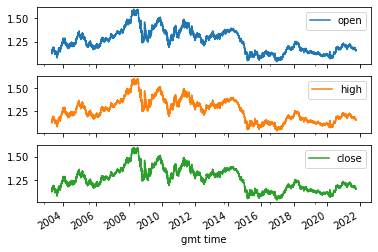

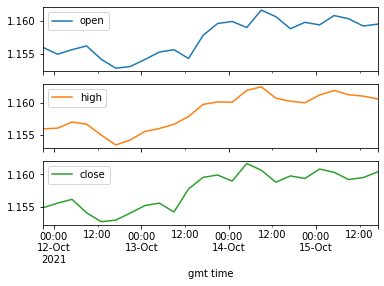

In [3]:
plot_features = df[my_plot_cols]
plot_features.index = date_days
hello = plot_features.plot(subplots=True)
days = 4 * 6
plot_features = df[my_plot_cols][-days:]
plot_features.index = date_days[-days:]
_ = plot_features.plot(subplots=True)

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,28860.0,1.254449,0.119505,1.03693,1.154278,1.242230,1.338760,1.59950
high,28860.0,1.256497,0.119839,1.03920,1.155988,1.244390,1.340750,1.60403
low,28860.0,1.252384,0.119131,1.03405,1.152438,1.239885,1.336512,1.59695
close,28860.0,1.254457,0.119503,1.03697,1.154285,1.242260,1.338763,1.59924
volume,28860.0,83078.835388,100637.239637,0.00000,20322.189925,47812.714850,102454.949700,752269.09380


In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

val_performance = {}
test_performance = {}

val_performance2 = {}
test_performance2 = {}

multi_val_performance = {}
multi_test_performance = {}

num_features = df.shape[1]

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [7]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}

        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result

        return result

    def __repr__(self):
        return '\n'.join([
            f'total window size: {self.total_window_size}',
            f'input indices: {self.input_indices}',
            f'label indices: {self.label_indices}',
            f'label column name(s): {self.label_columns}'])

    def plot(self, model=None, plot_col='unnamed', plot_time='unnamed', max_subplots=3):
        inputs, labels = self.example
        plot_col_index = self.column_indices[plot_col]

        plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel(plot_time)

In [8]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w1

total window size: 48
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [47]
label column name(s): ['close']

In [9]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w2

total window size: 7
input indices: [0 1 2 3 4 5]
label indices: [6]
label column name(s): ['close']

In [10]:
example_features = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[50:50+w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_features)

print('all shapes are: (batch, time, features)')
print(f'window shape: {example_features.shape}')
print(f'inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

all shapes are: (batch, time, features)
window shape: (3, 7, 5)
inputs shape: (3, 6, 5)
labels shape: (3, 1, 1)


In [11]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 6, 5)
labels shape (batch, time, features): (32, 1, 1)


In [12]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
single_step_window

total window size: 2
input indices: [0]
label indices: [1]
label column name(s): ['close']

In [13]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 1, 5)
labels shape (batch, time, features): (32, 1, 1)


In [14]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [15]:
baseline = Baseline(label_index=column_indices[my_col_name])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['baseline'] = baseline.evaluate(single_step_window.val)
test_performance['baseline'] = baseline.evaluate(single_step_window.test)

91/91 [==============================] - 0s 1ms/step - loss: 3.2931e-04 - mean_absolute_error: 0.0126


In [16]:
wide_window = WindowGenerator(
    input_width=my_width, label_width=my_width, shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
wide_window

total window size: 25
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
label column name(s): ['close']

In [17]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', baseline(wide_window.example[0]).shape)

input shape: (32, 24, 5)
output shape: (32, 24, 1)


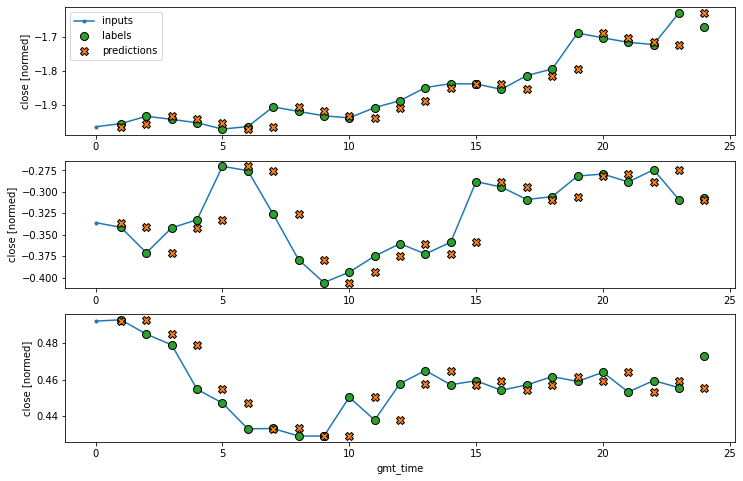

In [18]:
wide_window.plot(baseline, plot_col=my_col_name, plot_time=my_time_name)

In [19]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('input shape:', single_step_window.example[0].shape)
print('output shape:', linear(single_step_window.example[0]).shape)

input shape: (32, 1, 5)
output shape: (32, 1, 1)


In [20]:
def compile_and_fit(model, window, patience=2, epochs=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history

In [21]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
test_performance['linear'] = linear.evaluate(single_step_window.test)

Epoch 1/20
632/632 [==============================] - 2s 3ms/step - loss: 2.1777 - mean_absolute_error: 1.0480 - val_loss: 1.0582 - val_mean_absolute_error: 0.9916
Epoch 2/20
632/632 [==============================] - 2s 2ms/step - loss: 0.1262 - mean_absolute_error: 0.2421 - val_loss: 0.0203 - val_mean_absolute_error: 0.1354
Epoch 3/20
632/632 [==============================] - 2s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0506 - val_loss: 6.8675e-04 - val_mean_absolute_error: 0.0181
Epoch 4/20
632/632 [==============================] - 2s 3ms/step - loss: 0.0015 - mean_absolute_error: 0.0276 - val_loss: 6.0347e-04 - val_mean_absolute_error: 0.0172
Epoch 5/20
632/632 [==============================] - 2s 3ms/step - loss: 0.0015 - mean_absolute_error: 0.0269 - val_loss: 6.0930e-04 - val_mean_absolute_error: 0.0175
Epoch 6/20
91/91 [==============================] - 0s 2ms/step - loss: 5.8112e-04 - mean_absolute_error: 0.0177
CPU times: total: 30.4 s
Wall time: 11.9 s


In [22]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', baseline(wide_window.example[0]).shape)

input shape: (32, 24, 5)
output shape: (32, 24, 1)


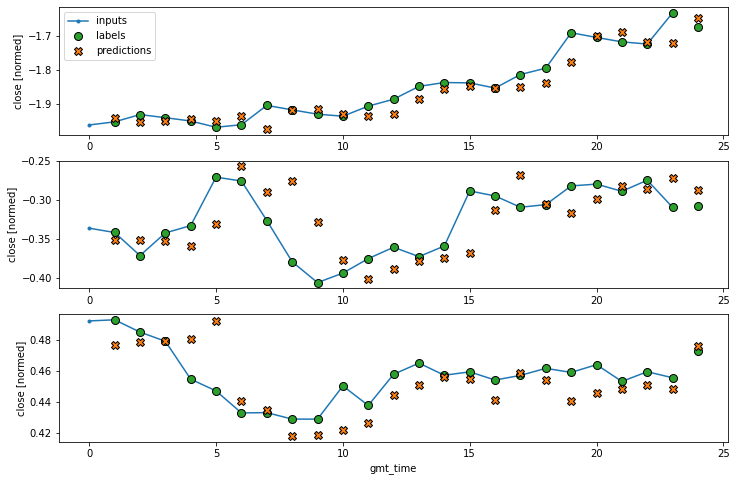

In [23]:
wide_window.plot(linear, plot_col=my_col_name, plot_time=my_time_name)

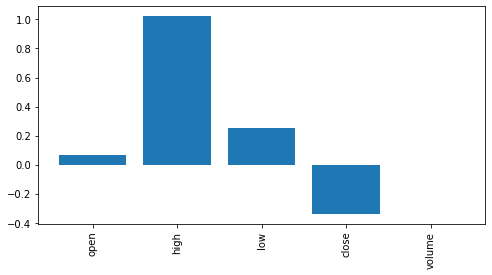

In [24]:
mpl.rcParams['figure.figsize'] = (8, 4)
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [25]:
mpl.rcParams['figure.figsize'] = (20, 8)
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [26]:
%%time
history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
test_performance['dense'] = dense.evaluate(single_step_window.test)

Epoch 1/20
632/632 [==============================] - 4s 5ms/step - loss: 0.0155 - mean_absolute_error: 0.0410 - val_loss: 4.5037e-04 - val_mean_absolute_error: 0.0152
Epoch 2/20
632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - mean_absolute_error: 0.0235 - val_loss: 6.5762e-04 - val_mean_absolute_error: 0.0204
Epoch 3/20
91/91 [==============================] - 0s 3ms/step - loss: 3.8483e-04 - mean_absolute_error: 0.0140
CPU times: total: 20.6 s
Wall time: 11 s


In [27]:
conv_window = WindowGenerator(
    input_width=my_conv_width, label_width=1, shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
conv_window

total window size: 4
input indices: [0 1 2]
label indices: [3]
label column name(s): ['close']

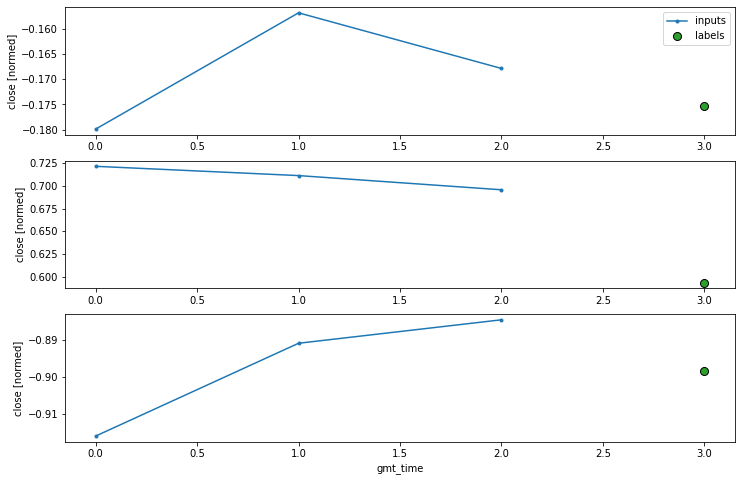

In [28]:
conv_window.plot(plot_col=my_col_name, plot_time=my_time_name)

In [29]:
multi_step_dense = tf.keras.Sequential([
    # shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # add back the time dimension
    # shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [30]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', multi_step_dense(conv_window.example[0]).shape)

input shape: (32, 3, 5)
output shape: (32, 1, 1)


In [31]:
%%time
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['multi_step'] = multi_step_dense.evaluate(conv_window.val)
test_performance['multi_step'] = multi_step_dense.evaluate(conv_window.test)

91/91 [==============================] - 0s 2ms/step - loss: 6.8770e-04 - mean_absolute_error: 0.0208
CPU times: total: 33.7 s
Wall time: 15.9 s


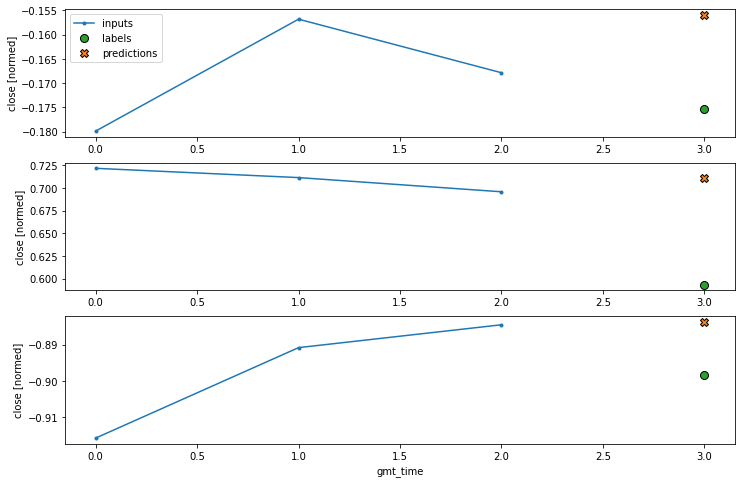

In [32]:
conv_window.plot(multi_step_dense, plot_col=my_col_name, plot_time=my_time_name)

In [33]:
print('input shape:', wide_window.example[0].shape)
try:
    print('output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

input shape: (32, 24, 5)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 15, but received input with shape (32, 120)

Call arguments received by layer "sequential_2" (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 5), dtype=float32)
  • training=None
  • mask=None


In [34]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(my_conv_width,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [35]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', conv_model(conv_window.example[0]).shape)

input shape: (32, 3, 5)
output shape: (32, 1, 1)


In [36]:
%%time
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['conv'] = conv_model.evaluate(conv_window.val)
test_performance['conv'] = conv_model.evaluate(conv_window.test)

91/91 [==============================] - 0s 3ms/step - loss: 7.5095e-04 - mean_absolute_error: 0.0225
CPU times: total: 1min 25s
Wall time: 44 s


In [37]:
print("wide window:")
print('input shape:', wide_window.example[0].shape)
print('labels shape:', wide_window.example[1].shape)
print('output shape:', conv_model(wide_window.example[0]).shape)

wide window:
input shape: (32, 24, 5)
labels shape: (32, 24, 1)
output shape: (32, 22, 1)


In [38]:
wide_conv_window = WindowGenerator(
    input_width=wide_input_width,
    label_width=wide_label_width,
    shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
wide_conv_window

total window size: 27
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
label column name(s): ['close']

In [39]:
print("wide conv window:")
print('input shape:', wide_conv_window.example[0].shape)
print('labels shape:', wide_conv_window.example[1].shape)
print('output shape:', conv_model(wide_conv_window.example[0]).shape)

wide conv window:
input shape: (32, 26, 5)
labels shape: (32, 24, 1)
output shape: (32, 24, 1)


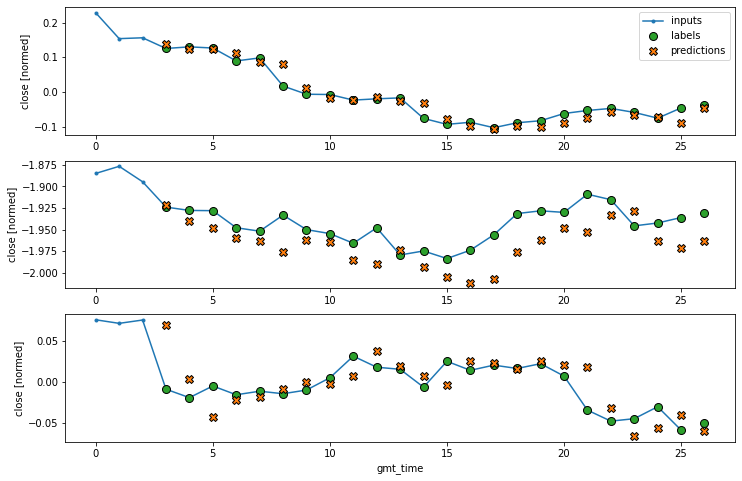

In [40]:
wide_conv_window.plot(conv_model, plot_col=my_col_name, plot_time=my_time_name)

In [41]:
lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [42]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', lstm_model(wide_window.example[0]).shape)

input shape: (32, 24, 5)
output shape: (32, 24, 1)


In [43]:
%%time
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['lstm'] = lstm_model.evaluate(wide_window.val)
test_performance['lstm'] = lstm_model.evaluate(wide_window.test)

90/90 [==============================] - 0s 4ms/step - loss: 3.4762e-04 - mean_absolute_error: 0.0132
CPU times: total: 2min 14s
Wall time: 1min 11s


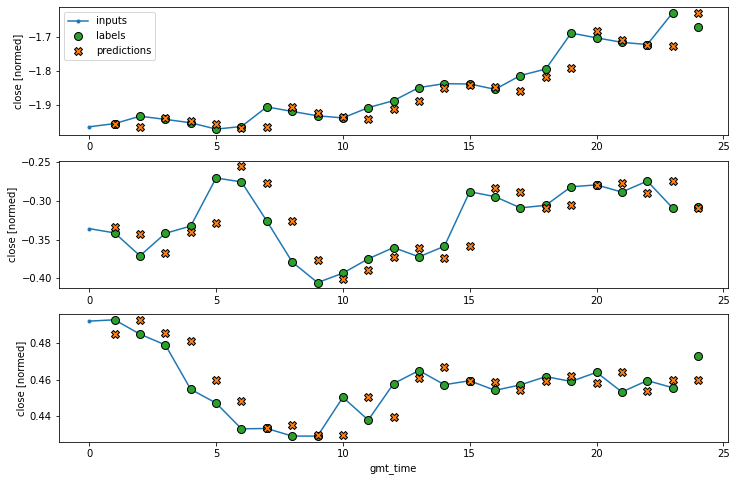

In [44]:
wide_window.plot(lstm_model, plot_col=my_col_name, plot_time=my_time_name)

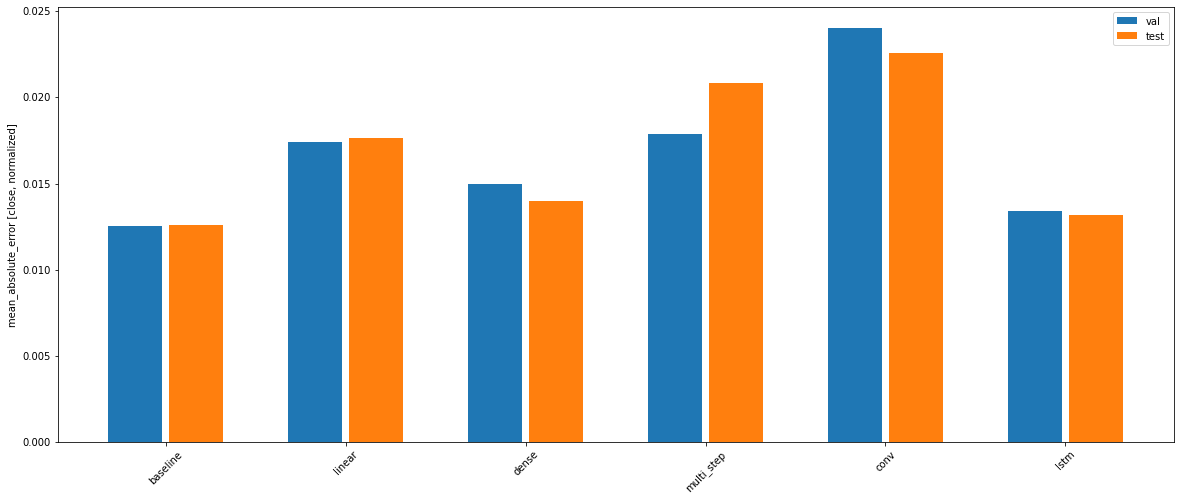

In [45]:
x = np.arange(len(test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]

plt.ylabel(f'mean_absolute_error [{my_col_name}, normalized]')
plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=test_performance.keys(), rotation=45)
_ = plt.legend()

In [46]:
for name, value in test_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

baseline    : 0.0126
linear      : 0.0177
dense       : 0.0140
multi_step  : 0.0208
conv        : 0.0225
lstm        : 0.0132


In [47]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels
    # if you don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 24, 5)
labels shape (batch, time, features): (32, 24, 5)


In [48]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance2['baseline'] = baseline.evaluate(wide_window.val)
test_performance2['baseline'] = baseline.evaluate(wide_window.test)

90/90 [==============================] - 0s 2ms/step - loss: 0.0194 - mean_absolute_error: 0.0441


In [49]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance2['dense'] = dense.evaluate(single_step_window.val)
test_performance2['dense'] = dense.evaluate(single_step_window.test)

91/91 [==============================] - 0s 3ms/step - loss: 0.0294 - mean_absolute_error: 0.0645


In [50]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance2['lstm'] = lstm_model.evaluate( wide_window.val)
test_performance2['lstm'] = lstm_model.evaluate( wide_window.test)

90/90 [==============================] - 0s 3ms/step - loss: 0.0182 - mean_absolute_error: 0.0427
CPU times: total: 2min 13s
Wall time: 1min 13s


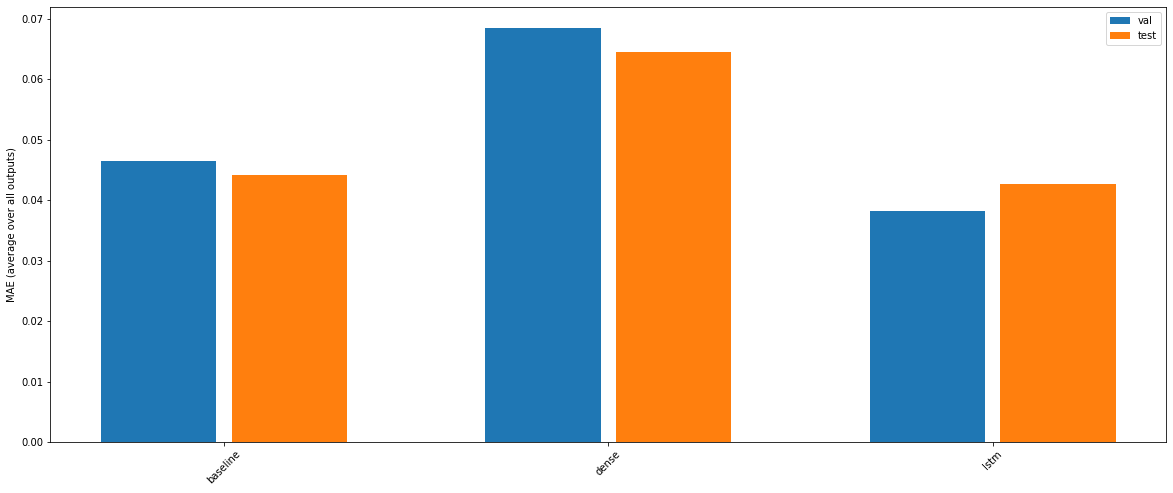

In [51]:
x = np.arange(len(test_performance2))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance2.values()]
test_mae = [v[metric_index] for v in test_performance2.values()]

plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=test_performance2.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [52]:
for name, value in test_performance2.items():
    print(f'{name:15s}: {value[1]:0.4f}')

baseline       : 0.0441
dense          : 0.0645
lstm           : 0.0427


total window size: 48
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
label column name(s): None

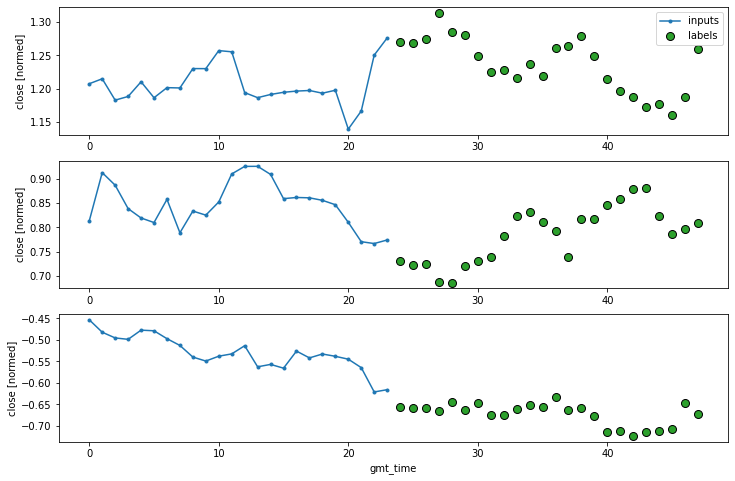

In [53]:
multi_window = WindowGenerator(input_width=24, label_width=my_out_steps, shift=my_out_steps,
                               train_df=train_df, val_df=val_df, test_df=test_df)
multi_window.plot(plot_col=my_col_name, plot_time=my_time_name)
multi_window

In [54]:
class MultistepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

In [55]:
last_baseline = MultistepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['last'] = last_baseline.evaluate(multi_window.val)
multi_test_performance['last'] = last_baseline.evaluate(multi_window.test)

89/89 [==============================] - 0s 1ms/step - loss: 0.0341 - mean_absolute_error: 0.0831


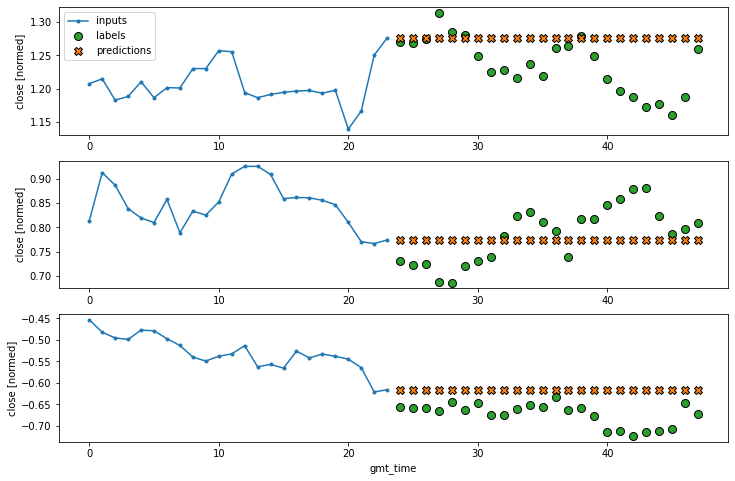

In [56]:
multi_window.plot(last_baseline, plot_col=my_col_name, plot_time=my_time_name)

In [57]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

In [58]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_test_performance['repeat'] = repeat_baseline.evaluate(multi_window.test)

89/89 [==============================] - 0s 2ms/step - loss: 0.0218 - mean_absolute_error: 0.0835


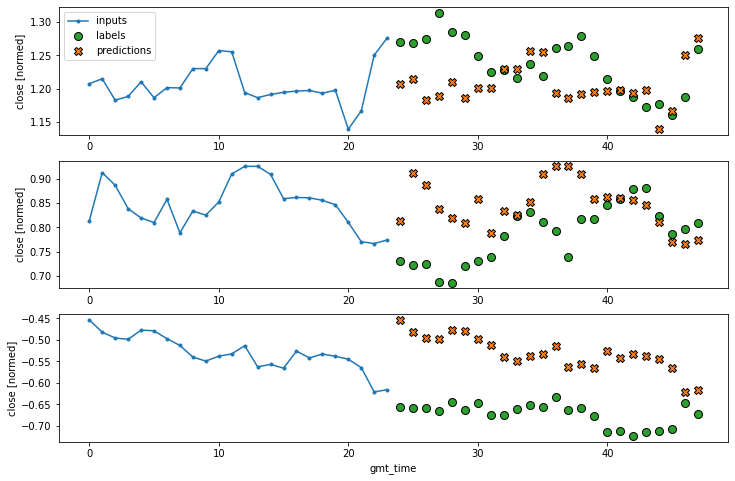

In [59]:
multi_window.plot(repeat_baseline, plot_col=my_col_name, plot_time=my_time_name)

In [60]:
multi_linear_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [61]:
%%time
history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['linear'] = multi_linear_model.evaluate(multi_window.val)
multi_test_performance['linear'] = multi_linear_model.evaluate(multi_window.test)

89/89 [==============================] - 0s 2ms/step - loss: 0.0575 - mean_absolute_error: 0.1246
CPU times: total: 28.7 s
Wall time: 13.8 s


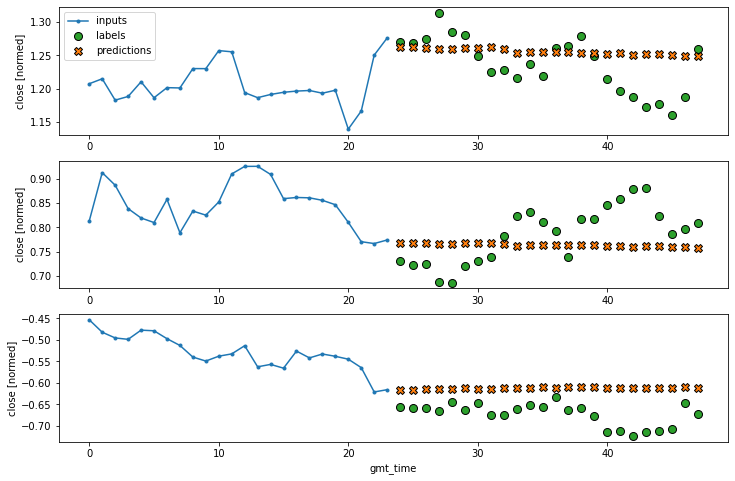

In [62]:
multi_window.plot(multi_linear_model, plot_col=my_col_name, plot_time=my_time_name)

In [63]:
multi_dense_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [64]:
%%time
history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['dense'] = multi_dense_model.evaluate(multi_window.val)
multi_test_performance['dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

179/179 [==============================] - 0s 3ms/step - loss: 0.0469 - mean_absolute_error: 0.1055
CPU times: total: 19.7 s
Wall time: 9 s


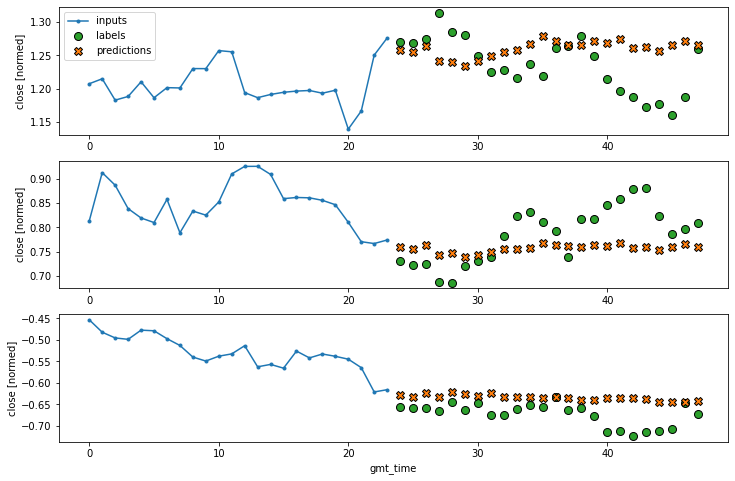

In [65]:
multi_window.plot(multi_dense_model, plot_col=my_col_name, plot_time=my_time_name)

In [66]:
multi_conv_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [67]:
%%time
history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['conv'] = multi_conv_model.evaluate(multi_window.val)
multi_test_performance['conv'] = multi_conv_model.evaluate(multi_window.test)

89/89 [==============================] - 0s 3ms/step - loss: 0.0437 - mean_absolute_error: 0.1026
CPU times: total: 17.6 s
Wall time: 8.47 s


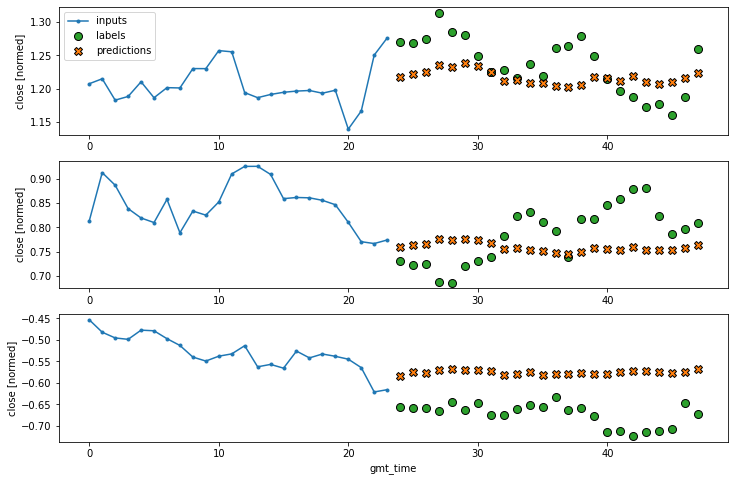

In [68]:
multi_window.plot(multi_conv_model, plot_col=my_col_name, plot_time=my_time_name)

In [69]:
multi_lstm_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [70]:
%%time
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_val_performance['lstm'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['lstm'] = multi_lstm_model.evaluate(multi_window.test)

89/89 [==============================] - 0s 3ms/step - loss: 0.0213 - mean_absolute_error: 0.0849
CPU times: total: 37.7 s
Wall time: 20.3 s


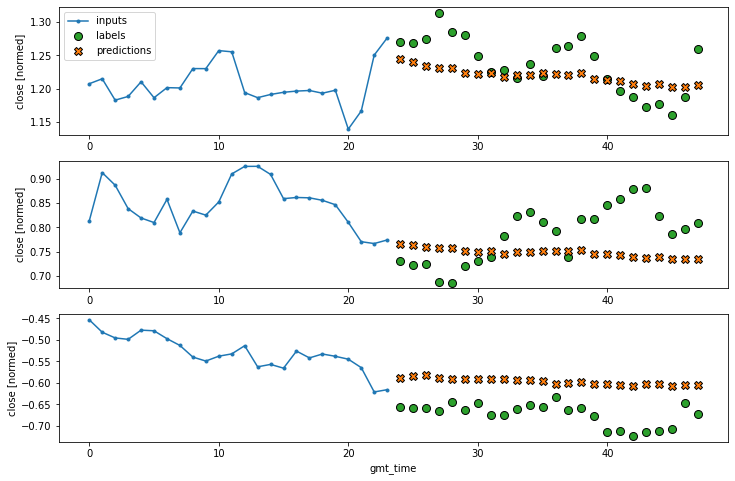

In [71]:
multi_window.plot(multi_lstm_model, plot_col=my_col_name, plot_time=my_time_name)

In [72]:
class Feedback(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state,
                                      training=training)

            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [73]:
feedback_model = Feedback(units=32, out_steps=OUT_STEPS)

In [74]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 5])

In [75]:
print('output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

output shape (batch, time, features):  (32, 24, 5)


In [76]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()
multi_val_performance['autoregr'] = feedback_model.evaluate(multi_window.val)
multi_test_performance['autoregr'] = feedback_model.evaluate(multi_window.test)

89/89 [==============================] - 2s 24ms/step - loss: 0.0276 - mean_absolute_error: 0.0979


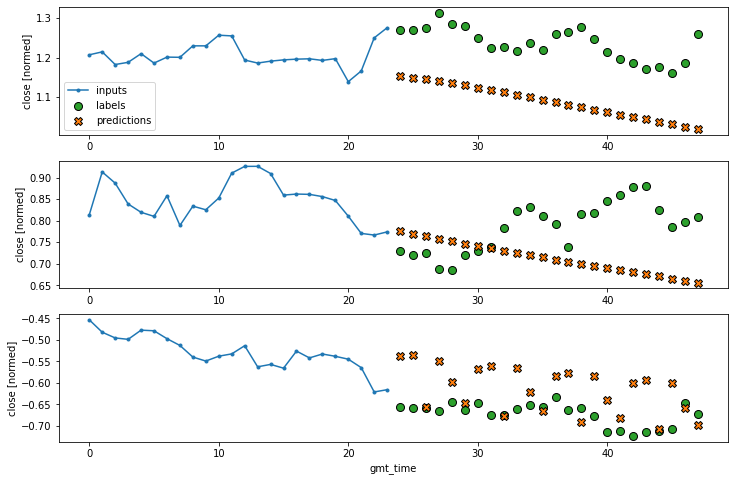

In [77]:
multi_window.plot(feedback_model, plot_col=my_col_name, plot_time=my_time_name)

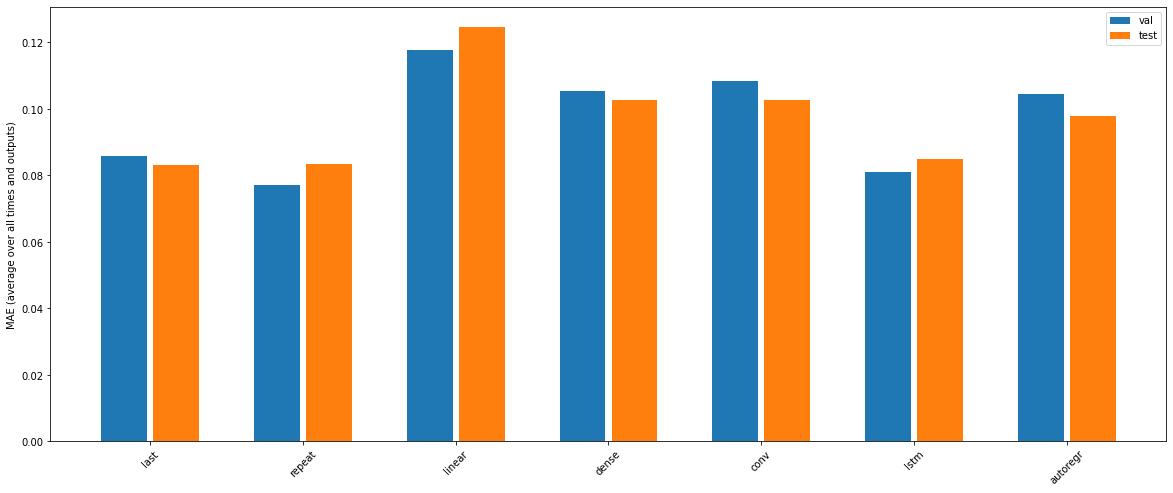

In [78]:
x = np.arange(len(multi_test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()